# Conformal Experiment: Gradual Overlap

- OvA
- Softmax

In [1]:
import json

import numpy as np
import torch
import matplotlib.pyplot as plt

from scipy import stats
# from scipy.optimize import brentq, ridder

In [2]:
n_classes = 10
n_experts = 10

# Metric Calculation

In [3]:
def get_expert_prediction(experts, prediction_set_i, method="voting"):
    ensemble_expert_pred_i = np.array(experts_test)[prediction_set_i][:, i]
    if method == "voting":
        exp_prediction = stats.mode(ensemble_expert_pred_i).mode if len(ensemble_expert_pred_i)!=0 else []
        
    if method == "last": 
        exp_prediction = ensemble_expert_pred_i[-1] if len(ensemble_expert_pred_i)!=0 else []
        
    if method == "random":
        idx = np.random.randint(len(ensemble_expert_pred_i)) if len(ensemble_expert_pred_i)!=0 else -1
        exp_prediction = ensemble_expert_pred_i[idx] if idx!=-1 else []
        
    return exp_prediction

## OvA

In [6]:
# === OvA ===
confs = []
exps = []
true = []
path = "ova_gradual_overlap/"

p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
seed = "_seed_436"
for p in p_out:
    model_name = '_p_out_' + str(p)
    with open(path + 'confidence_multiple_experts' + model_name + seed + '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + seed + '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + seed + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    # DANI Correction ===
    c = c.sigmoid()
    # DANI Correction ===
    confs.append(c)

In [7]:
n_val = int(0.8 * len(true[0]))
n_test = len(true[0]) - n_val
print("N val:{}".format(n_val))
print("N test:{}".format(n_test))

N val:7372
N test:1844


In [8]:
idx = np.array([1]*n_val + [0]*(len(true[0]) - n_val)) > 0
assert int(sum(idx)) == n_val
np.random.shuffle(idx)

In [10]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
alpha = 0.1
n_classes = 10
n_experts = 10
n_classes_exp = n_classes + n_experts


In [11]:
# utility functions

def get_kparam(paramtune_probs,paramtune_gt_labels, alpha):
    temp = paramtune_probs * paramtune_gt_labels
    flat = temp.reshape(-1)
    # indices where the temp is True
    non_zero_indices = torch.nonzero(flat)
    # confidence of the correct experts
    correct_experts_confs = flat[non_zero_indices]
    return torch.quantile(torch.sort(correct_experts_confs, descending=True)[0], 1- alpha, interpolation='higher')

def false_negative_rate(prediction_set, gt_labels):
    return 1 - ((prediction_set*gt_labels).sum(axis=1)/gt_labels.sum(axis=1)).mean()

def get_lhat(calib_loss_table, lambdas, alpha, B=1):
    n = calib_loss_table.shape[0]
    rhat = calib_loss_table.mean(axis=0)
    lhat_idx = max(np.argmax(((n/(n+1)) * rhat + B/(n+1) ) >= alpha) - 1, 0) # Can't be -1.
    return lambdas[lhat_idx]
    
def conformal_risk_control(probs_experts, gt_labels, alpha=None, lower=0, upper=1):

    num_lam = 1500
    lambdas_example_table = np.linspace(lower, upper, num_lam)

    # Run the conformal risk control procedure
    loss_table = np.zeros((probs_experts.shape[0], num_lam))

    from tqdm import tqdm
    for j in range(num_lam):
        est_labels = probs_experts >= lambdas_example_table[j]
        loss = false_negative_rate(est_labels, gt_labels)
        loss_table[:,j] = loss
    
    lamhat = get_lhat(loss_table, lambdas_example_table, alpha)
    return lamhat


    # n = probs_experts.shape[0]
    # idx = torch.where(probs_experts > float(upper))
    # print(idx)
    # probs_experts[idx] = float(upper)
    # def lamhat_threshold(lam): return false_negative_rate(probs_experts>=(1-lam), gt_labels) - ((n+1)/n*alpha - 1/(n+1))
    # lamhat = ridder(lamhat_threshold, lower, upper)
    # return lamhat

import torch.nn as nn
class ConformalRiskControl(nn.Module):
    def __init__(self, calib_probs, calib_gt_labels, alpha, kparam=None,betaparam=None, prop=0.3, lower=0, upper=1, model=None):
        super(ConformalRiskControl, self).__init__()
        self.model=model
        self.alpha = alpha

        if (kparam == None or betaparam == None):
            kparam, betaparam, calib_probs, calib_gt_labels = pick_parameters(calib_probs, calib_gt_labels, prop=prop, alpha=alpha)

        self.kparam = kparam
        self.betaparam = betaparam

        calib_probs = (1 + betaparam)*calib_probs - betaparam*kparam
        calib_gt_labels = calib_gt_labels

        self.lamhat = conformal_risk_control(calib_probs, calib_gt_labels, alpha=alpha, upper=upper, lower=lower)

    def forward(self, probs):
        with torch.no_grad():
            probs = (1 + self.betaparam)*probs - self.betaparam*self.kparam
            prediction_sets = probs >= self.lamhat
            return prediction_sets


        
def validate(conformal_model, probs, labels):
    with torch.no_grad():
        prediction_sets = conformal_model(probs)
        size = np.sum(prediction_sets.numpy(), axis=1)
        FNR = false_negative_rate(prediction_sets, labels)
    return {'size' : size.tolist(), 'FNR' : FNR}


def get_betaparam(paramtune_probs, paramtune_gt_labels, kstar, alpha):
    best_size = paramtune_probs.shape[1] # Total number of experts

    for temp_beta in np.linspace(3.5, 1e-3, 50):
        conformal_model = ConformalRiskControl(paramtune_probs, paramtune_gt_labels, alpha, kparam=kstar, betaparam=temp_beta)
        metrics = validate(conformal_model, paramtune_probs, paramtune_gt_labels)
        mean_size = np.mean(metrics['size'])
        if mean_size < best_size:
            best_size = mean_size
            betastar = temp_beta
    return betastar



def pick_parameters(calibration_probs, gt_labels, prop=0.3, alpha=0.1):
    '''
    first split the calibration_probs into two separate datasets: one for hyperparam tuning and another for conformal risk
    calibration_probs: [N, E], N = deferred data points, E = no. of experts
    gt_labels: [N, E] Boolen tensor: True at the index where the expert is correct
    '''
    import torch.utils.data as tdata
    N = calibration_probs.shape[0]
    num_paramtune = int(np.ceil(prop * calibration_probs.shape[0]))
    idx = np.array([1]*num_paramtune + [0]*(N - num_paramtune)) > 0
    assert int(sum(idx)) == num_paramtune
    np.random.shuffle(idx)
    
    paramtune_probs, paramtune_gt_labels = calibration_probs[idx,:], gt_labels[idx,:]
    calib_probs, calib_gt_labels = calibration_probs[~idx,:], gt_labels[~idx,:]
    print("Number of hyperparameter tuning samples {}\n Number of conformal risk samples {}".format(
        paramtune_probs.shape[0], calib_probs.shape[0]))

    # pick kparam
    kstar = get_kparam(paramtune_probs, paramtune_gt_labels, alpha)

    # pick beta
    betastar = get_betaparam(paramtune_probs, paramtune_gt_labels, kstar, alpha)

    return kstar, betastar, calib_probs, calib_gt_labels

In [12]:
# Method dict ===
method_list_ova = ["standard", "last", "random", "voting"]
method_dict_ova = {"standard": [],
               "last": [],
               "random": [],
               "voting": []}

for method in method_list_ova:
    print("Method: {}\n".format(method))
    for i, p in enumerate(p_out):
        # =============
        # = Get Probs =
        # =============

        probs = confs[i]
        experts = exps[i]
#         experts = experts[::-1]  # reverse order!
        y_true = true[-i]

        # Val/Calibration ===
        probs_val = probs[idx, n_classes:]
        experts_val = [np.array(exp)[idx].tolist() for exp in experts]
        y_true_val = np.array(y_true)[idx].astype(list)

        # Test ===
        probs_test = probs[~idx, n_classes:]
        experts_test = [np.array(exp)[~idx].tolist() for exp in experts]
        y_true_test = np.array(y_true)[~idx].astype(list)


        # =============
        # = Conformal =
        # =============

        # Calculate Q_hat ===

        # === Only on deferred samples
        _, predicted = torch.max(probs[idx].data, 1)
        r = (predicted >= n_classes_exp - n_experts)

        # Filter 
        probs_experts = probs_val[r]
        experts_val = [np.array(exp)[r] for exp in experts_val]
        y_true_val = np.array(y_true_val)[r]



        #print(probs_experts.shape, np.array(experts_val).shape, y_true_val.shape)

        gt_labels = (np.array(experts_val) == np.array(y_true_val)).T

        #print("gt_labels shape {}".format(gt_labels.shape))

        n = gt_labels.shape[0]

        average_correct_experts = np.mean(gt_labels)

        print("average number of correct experts {}".format(average_correct_experts))

        #print(probs_experts[:2,:])
        #print(gt_labels[:2,:])

        # '''
        # Choose the kstar parameter

        # '''

        # # temp is true for the indices where the experts predict correctly
        # temp = probs_experts * gt_labels
        # print(temp.shape)
        # flat = temp.reshape(-1)
        # print(flat.shape)
        # # indices where the temp is True
        # non_zero_indices = torch.nonzero(flat)
        # print(non_zero_indices[:5])
        # # confidence of the correct experts
        # correct_experts_confs = flat[non_zero_indices]
        # print(correct_experts_confs.shape)
        
        # kstar = get_expert_prediction(correct_experts_confs, alpha)
        # print(kstar)

        cmodel = ConformalRiskControl(probs_experts, gt_labels, alpha, kparam=None,betaparam=None, prop=0.3, model=None)

        


        '''test'''

        # === Only on deferred samples
        # _, predicted_test = torch.max(probs[~idx].data, 1)
        # r_test = (predicted_test >= n_classes_exp - n_experts)

        # # Filter 
        # probs_test = probs_test[r_test]
        # experts_test = [np.array(exp)[r_test] for exp in experts_test]
        # y_true_test = np.array(y_true_test)[r_test]

        # gt_labels_test = (np.array(experts_test) == np.array(y_true_test)).T
        # metrics = validate(cmodel, probs_test, gt_labels_test)

        # metrics["size"] = np.average(metrics["size"])
        # print(p, metrics)

        # # Run the conformal risk control procedure
        # def lamhat_threshold(lam): return false_negative_rate(probs_experts>=lam, gt_labels) - ((n+1)/n*alpha - 1/(n+1))
        # lamhat = brentq(lamhat_threshold, 0, 1)
        # prediction_sets = probs_experts >= lamhat
        # #print(prediction_sets.shape, torch.sum(prediction_sets, dim=1))
        # print(f"The empirical FNR is: {false_negative_rate(prediction_sets, gt_labels)} and the threshold value is: {lamhat}")
        #print("Average Prediction Set Size is: {}".format(np.mean(torch.sum(prediction_sets, dim=1).numpy())))

        # # Model expert probs ===
        # # Sort J model outputs for experts
        # sort, pi = probs_experts.sort(dim=1, descending=True)

        # # Correctness experts ===
        # # Check if experts are correct 
        # correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
        # # idx for correct experts: [[0,1,2], [1,2], [], ...]
        # correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

        # # obtain the last expert to be retrieved. If empty, then add all values.
        # # indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
        # pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
        # pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

        # # obtain real expert index back, e.g. [2,1,-1,...]
        # pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]

        # scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
        # n_quantile = r.sum()
        # qhat = torch.quantile(scores, np.ceil((n_quantile + 1) * (1 - alpha)) / n_quantile, interpolation="higher")

        # print("Q_hat {}: {}".format(p, qhat))

        # =============
        # = Metrics =
        # =============

        # === Initalize ====

        correct = 0
        correct_sys = 0
        exp = 0
        exp_total = 0
        total = 0
        real_total = 0
        alone_correct = 0
        prediction_set_size = 0
        prediction_set_len = 0

        # Individual Expert Accuracies === #
        expert_correct_dic = {k: 0 for k in range(len(experts_test))}
        expert_total_dic = {k: 0 for k in range(len(experts_test))}

        probs_test_exp = probs_test
        probs_test_model = probs[~idx]

        # Predicted value 
        _, predicted = torch.max(probs_test_model.data, 1)

        # Classifier alone prediction
        _, prediction = torch.max(probs_test_model.data[:, :(n_classes_exp - n_experts)],1)

        labels = y_true_test
        for i in range(0, n_test):
            r = (predicted[i].item() >= n_classes_exp - n_experts)
            alone_correct += (prediction[i] == labels[i]).item()

            # Non-deferred 
            if r == 0:
                total += 1
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()

            # Deferred 
            if r == 1:
                # Non Conformal prediction ===
                if method=="standard":
                    deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
                    exp_prediction = experts_test[deferred_exp][i]
                    
                    # Conformal prediction ===        
                else:                
                    # Sort J model outputs for experts. sorted probs and sorted indexes
                    #sort_i, pi_i = probs_test_exp[i].sort(descending=True)
                    # Get last sorted index to be below Q_hat
                    #pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()
                    # Prediction sets
                    prediction_set_i = cmodel(probs_test_exp[i])# >= lamhat #(pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets
                    prediction_set_len = sum(prediction_set_i)    

                    # - Get expert prediction depending on method
                    # ======
                    exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
                    # ======



                # Deferral accuracy: No matter expert ===
                exp += (exp_prediction == labels[i])
                exp_total += 1
                # Individual Expert Accuracy ===
                # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
                # expert_total_dic[deferred_exp] += 1
                #
                correct_sys += (exp_prediction == labels[i])
                prediction_set_size += prediction_set_len

            real_total += 1

        #  ===  Coverage  === #    
        cov = 100 * total / real_total

        #  === Individual Expert Accuracies === #
        expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
                     in range(len(experts_test))}

        # Add expert accuracies dict
        to_print = {"coverage": cov,
                    "system_accuracy": 100 * correct_sys / real_total,
                    "expert_accuracy": 100 * exp / (exp_total + 0.0002),
                    "classifier_accuracy": 100 * correct / (total + 0.0001),
                    "alone_classifier": 100 * alone_correct / real_total,
                    "prediction_set_size": prediction_set_size / (exp_total + 0.00002)}
        print(to_print, flush=True)

        # Save to method dict ===
        method_dict_ova[method].append(to_print)

         
    #     break
    # break
    



Method: standard

average number of correct experts 0.2673036093418259
Number of hyperparameter tuning samples 424
 Number of conformal risk samples 989
{'coverage': 82.80911062906725, 'system_accuracy': 89.3709327548807, 'expert_accuracy': 71.60878762852515, 'classifier_accuracy': 93.05827812322998, 'alone_classifier': 88.44902386117137, 'prediction_set_size': 0.0}
average number of correct experts 0.3541613857203211
Number of hyperparameter tuning samples 711
 Number of conformal risk samples 1656
{'coverage': 70.93275488069415, 'system_accuracy': 90.40130151843817, 'expert_accuracy': 76.30594167688744, 'classifier_accuracy': 96.17736267757167, 'alone_classifier': 87.85249457700651, 'prediction_set_size': 0.0}
average number of correct experts 0.510174880763116
Number of hyperparameter tuning samples 755
 Number of conformal risk samples 1761
{'coverage': 65.13015184381779, 'system_accuracy': 91.81127982646422, 'expert_accuracy': 80.09328768482499, 'classifier_accuracy': 98.084921058

## Softmax

In [13]:
# === Softmax ===
n_classes = 10
probs_softmax = []
confs = []
exps = []
true = []

path = "softmax_gradual_overlap/"
n_experts = 10
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]

seed = "_seed_436"

for p in p_out:
    model_name = '_p_out_' + str(p)
    with open(path + 'confidence_multiple_experts' + model_name + seed +  '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + seed+  '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + seed + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    print(c.shape)
    # DANI Correction ===
    c = c.softmax(dim=1)
    probs_softmax.append(c)
    # DANI Correction ===

    temp = 0
    for i in range(n_experts):
        temp += c[:, (n_classes + n_experts) - (i + 1)]
    prob = c / (1.0 - temp).unsqueeze(-1)
    confs.append(prob)


torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])


In [14]:
# Method dict ===
method_list_softmax = ["standard", "last", "random", "voting"]
method_dict_softmax = {"standard": [],
               "last": [],
               "random": [],
               "voting": []}

for method in method_list_softmax:
    
    print("Method: {}\n".format(method))
    for i, p in enumerate(p_out):
        # =============
        # = Get Probs =
        # =============

        probs = probs_softmax[i]
        experts = exps[i]
#         experts = experts[::-1]  # reverse order!
        y_true = true[-i]

        # Val/Calibration ===
        probs_val = probs[idx, n_classes:]
        experts_val = [np.array(exp)[idx].tolist() for exp in experts]
        y_true_val = np.array(y_true)[idx].astype(list)

        # Test ===
        probs_test = probs[~idx, n_classes:]
        experts_test = [np.array(exp)[~idx].tolist() for exp in experts]
        y_true_test = np.array(y_true)[~idx].astype(list)


        # =============
        # = Conformal =
        # =============

        # Calculate Q_hat ===

        # === Only on deferred samples
        _, predicted = torch.max(probs[idx].data, 1)
        r = (predicted >= n_classes_exp - n_experts)

        # Filter 
        probs_experts = probs_val[r]
        experts_val = [np.array(exp)[r] for exp in experts_val]
        y_true_val = np.array(y_true_val)[r]


        # def false_negative_rate(prediction_set, gt_labels):
        #     return 1 - ((prediction_set*gt_labels).sum(axis=1)/gt_labels.sum(axis=1)).mean()

        # #print(probs_experts.shape, np.array(experts_val).shape, y_true_val.shape)

        gt_labels = (np.array(experts_val) == np.array(y_true_val)).T

        #print(gt_labels.shape)

        # n = gt_labels.shape[0]


        # # Run the conformal risk control procedure
        # def lamhat_threshold(lam): return false_negative_rate(probs_experts>=(lam), gt_labels) - ((n+1)/n*alpha - 1/(n+1))
        # lamhat = brentq(lamhat_threshold, 0, 1)
        # prediction_sets = probs_experts >= lamhat
        # print(f"The empirical FNR is: {false_negative_rate(prediction_sets, gt_labels)} and the threshold value is: {lamhat}")


        cmodel = ConformalRiskControl(probs_experts, gt_labels, alpha, kparam=None,betaparam=None, lower=0, upper=0.1, prop=0.3, model=None)


        # Model expert probs ===
        # Sort J model outputs for experts
        #sort, pi = probs_experts.sort(dim=1, descending=True)

        # Correctness experts ===
        # Check if experts are correct 
        #correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
        # idx for correct experts: [[0,1,2], [1,2], [], ...]
        #correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

        # obtain the last expert to be retrieved. If empty, then add all values.
        # indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
        #pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
        #pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

        # obtain real expert index back, e.g. [2,1,-1,...]
        #pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]

        #scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
        #n_quantile = r.sum()
        #qhat = torch.quantile(scores, np.ceil((n_quantile + 1) * (1 - alpha)) / n_quantile, interpolation="higher")

        #print("Q_hat {}: {}".format(p, qhat))


        # =============
        # = Metrics =
        # =============

        # === Initalize ====

        correct = 0
        correct_sys = 0
        exp = 0
        exp_total = 0
        total = 0
        real_total = 0
        alone_correct = 0
        prediction_set_size = 0
        prediction_set_len = 0

        # Individual Expert Accuracies === #
        expert_correct_dic = {k: 0 for k in range(len(experts_test))}
        expert_total_dic = {k: 0 for k in range(len(experts_test))}

        probs_test_exp = probs_test
        probs_test_model = probs[~idx]

        # Predicted value 
        _, predicted = torch.max(probs_test_model.data, 1)

        # Classifier alone prediction
        _, prediction = torch.max(probs_test_model.data[:, :(n_classes_exp - n_experts)],1)

        labels = y_true_test
        for i in range(0, n_test):
            r = (predicted[i].item() >= n_classes_exp - n_experts)
            alone_correct += (prediction[i] == labels[i]).item()

            # Non-deferred 
            if r == 0:
                total += 1
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()

            # Deferred 
            if r == 1:
                # Non Conformal prediction ===
                if method=="standard":
                    deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
                    exp_prediction = experts_test[deferred_exp][i]
                    
                    # Conformal prediction ===        
                else:                
                    # Sort J model outputs for experts. sorted probs and sorted indexes
                    #sort_i, pi_i = probs_test_exp[i].sort(descending=True)
                    # Get last sorted index to be below Q_hat
                    #pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()
                    # Prediction sets
                    prediction_set_i = cmodel(probs_test_exp[i]) # >= lamhat #(pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets
                    prediction_set_len = sum(prediction_set_i)        

                    # - Get expert prediction depending on method
                    # ======
                    exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
                    # ======



                # Deferral accuracy: No matter expert ===
                exp += (exp_prediction == labels[i])
                exp_total += 1
                # Individual Expert Accuracy ===
                # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
                # expert_total_dic[deferred_exp] += 1
                #
                correct_sys += (exp_prediction == labels[i])
                prediction_set_size += prediction_set_len

            real_total += 1

        #  ===  Coverage  === #    
        cov = 100 * total / real_total

        #  === Individual Expert Accuracies === #
        expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
                     in range(len(experts_test))}

        # Add expert accuracies dict
        to_print = {"coverage": cov,
                    "system_accuracy": 100 * correct_sys / real_total,
                    "expert_accuracy": 100 * exp / (exp_total + 0.0002),
                    "classifier_accuracy": 100 * correct / (total + 0.0001),
                    "alone_classifier": 100 * alone_correct / real_total,
                    "prediction_set_size": prediction_set_size / (exp_total + 0.00002)}
        print(to_print, flush=True)

        # Save to method dict === 
        method_dict_softmax[method].append(to_print)



Method: standard

Number of hyperparameter tuning samples 1014
 Number of conformal risk samples 2363
{'coverage': 55.477223427331886, 'system_accuracy': 87.96095444685466, 'expert_accuracy': 82.94760464126563, 'classifier_accuracy': 91.98435073466757, 'alone_classifier': 86.55097613882863, 'prediction_set_size': 0.0}
Number of hyperparameter tuning samples 1224
 Number of conformal risk samples 2856
{'coverage': 45.60737527114968, 'system_accuracy': 89.09978308026031, 'expert_accuracy': 86.04185721996865, 'classifier_accuracy': 92.74671905508691, 'alone_classifier': 86.49674620390455, 'prediction_set_size': 0.0}
Number of hyperparameter tuning samples 1565
 Number of conformal risk samples 3650
{'coverage': 27.386117136659436, 'system_accuracy': 92.24511930585683, 'expert_accuracy': 92.6064088713355, 'classifier_accuracy': 91.28711063621571, 'alone_classifier': 88.44902386117137, 'prediction_set_size': 0.0}
Number of hyperparameter tuning samples 1576
 Number of conformal risk samples

## Plot results

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rc

# # === Latex Options === #
rc('font', family='serif')
rc('text', usetex=True)

# === Matplotlib Options === #
cm = plt.cm.get_cmap('tab10')
plot_args = {"marker": "o",
             "markeredgecolor": "k",
             "markersize": 10,
             "linewidth": 8
             }
sns.set_context("talk", font_scale=1.3)
fig_size = (7,7)


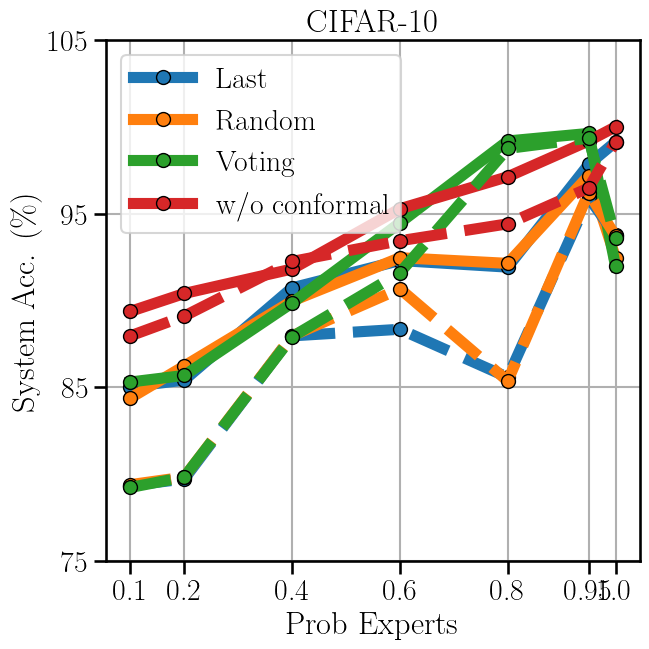

In [16]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]


# OvA ===
sys_acc_standard_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["standard"]])
sys_acc_last_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["last"]])
sys_acc_random_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["random"]])
sys_acc_voting_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["voting"]])

# Softmax ===
sys_acc_standard_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["standard"]])
sys_acc_last_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["last"]])
sys_acc_random_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["random"]])
sys_acc_voting_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["voting"]])


f, ax = plt.subplots(1, 1, figsize=fig_size)
# OvA ===
ax.plot(p_out, sys_acc_last_ova, "-", label=r"Last", color=cm(0), **plot_args)
ax.plot(p_out, sys_acc_random_ova, "-", label=r"Random", color=cm(1), **plot_args)
ax.plot(p_out, sys_acc_voting_ova, "-", label=r"Voting", color=cm(2), **plot_args)
ax.plot(p_out, sys_acc_standard_ova, "-", label=r"w/o conformal", color=cm(3), **plot_args)

# Softmax ===
ax.plot(p_out, sys_acc_last_softmax, "--", color=cm(0), **plot_args)
ax.plot(p_out, sys_acc_random_softmax, "--", color=cm(1), **plot_args)
ax.plot(p_out, sys_acc_voting_softmax, "--", color=cm(2), **plot_args)
ax.plot(p_out, sys_acc_standard_softmax, "--", color=cm(3), **plot_args)

plt.xticks(p_out, p_out)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'System Acc. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()

plt.savefig("system_acc_gradual_overlap_regularized_risk_control.pdf")

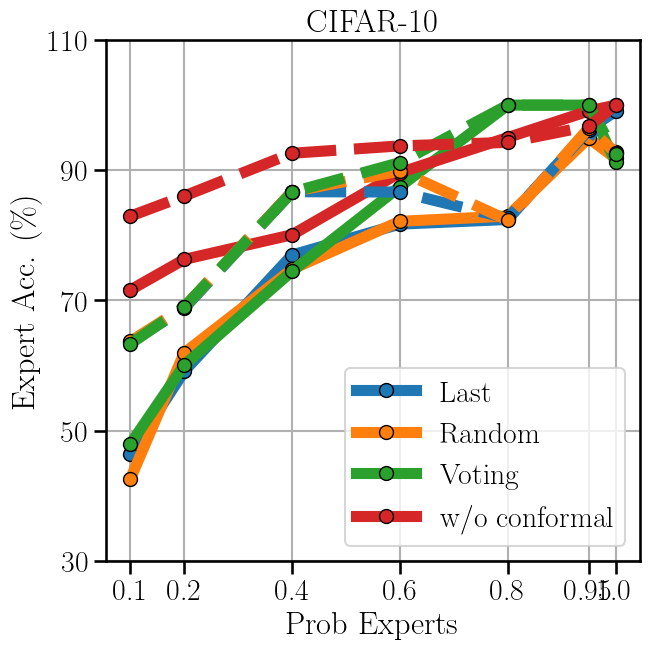

In [17]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]


# OvA ===
exp_acc_standard_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["standard"]])
exp_acc_last_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["last"]])
exp_acc_random_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["random"]])
exp_acc_voting_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["voting"]])

# Softmax ===
exp_acc_standard_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["standard"]])
exp_acc_last_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["last"]])
exp_acc_random_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["random"]])
exp_acc_voting_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["voting"]])


f, ax = plt.subplots(1, 1, figsize=fig_size)
# OvA ===
ax.plot(p_out, exp_acc_last_ova, "-", label=r"Last", color=cm(0), **plot_args)
ax.plot(p_out, exp_acc_random_ova, "-", label=r"Random", color=cm(1), **plot_args)
ax.plot(p_out, exp_acc_voting_ova, "-", label=r"Voting", color=cm(2), **plot_args)
ax.plot(p_out, exp_acc_standard_ova, "-", label=r"w/o conformal", color=cm(3), **plot_args)

# Softmax ===
ax.plot(p_out, exp_acc_last_softmax, "--", color=cm(0), **plot_args)
ax.plot(p_out, exp_acc_random_softmax, "--", color=cm(1), **plot_args)
ax.plot(p_out, exp_acc_voting_softmax, "--", color=cm(2), **plot_args)
ax.plot(p_out, exp_acc_standard_softmax, "--", color=cm(3), **plot_args)

plt.xticks(p_out, p_out)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Expert Acc. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()

plt.savefig("expert_acc_gradual_overlap_regularized_risk_control.pdf")


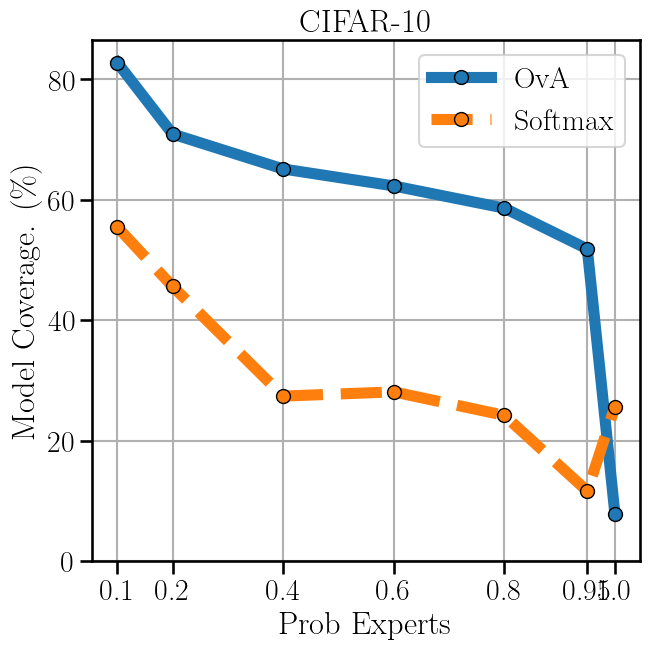

In [18]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
coverage_ova = np.array([method_d["coverage"] for method_d in method_dict_ova["last"]])
coverage_softmax = np.array([method_d["coverage"] for method_d in method_dict_softmax["last"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(p_out, coverage_ova, "-", label=r"OvA", **plot_args)
ax.plot(p_out, coverage_softmax, "--", label=r"Softmax", **plot_args)

plt.xticks(p_out, p_out)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Model Coverage. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


plt.savefig("coverage_gradual_overlap_regularized_risk_control.pdf")


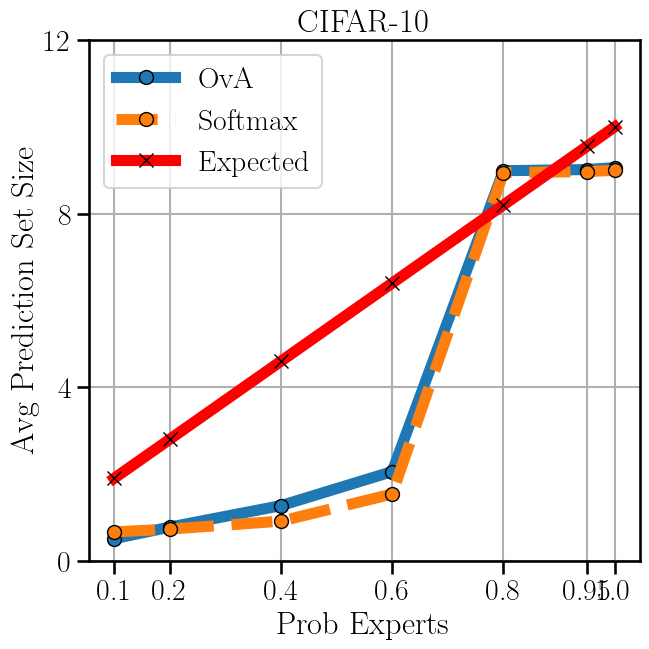

In [19]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
expected_size = []
for p in p_out:
    expected_size.append(1*1.0 + 9*(p))

{"marker": "o",
             "markeredgecolor": "k",
             "markersize": 10,
             "linewidth": 8
             }
prediction_set_size_ova = np.array([method_d["prediction_set_size"] for method_d in method_dict_ova["random"]])
prediction_set_size_softmax = np.array([method_d["prediction_set_size"] for method_d in method_dict_softmax["random"]])
f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(p_out, prediction_set_size_ova, "-", label=r"OvA", **plot_args)
ax.plot(p_out, prediction_set_size_softmax, "--", label=r"Softmax", **plot_args)
ax.plot(p_out, expected_size, color="red", marker="x", markeredgecolor="k", markersize=10, linewidth=8, label=r"Expected")

plt.xticks(p_out, p_out)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Avg Prediction Set Size')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


plt.savefig("prediction_set_size_gradual_overlap_regularized_risk_control.pdf")